In [1]:
import numpy as np
import torch

In [2]:
# !pip install pytorch-pretrained-bert

In [3]:
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

In [4]:
model_version = 'bert-base-uncased'
model = BertForMaskedLM.from_pretrained(model_version)
model.eval()
# cuda = torch.cuda.is_available()
# if cuda:
#     model = model.cuda(0)

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained(model_version, do_lower_case=model_version.endswith("uncased"))


In [ ]:
audio = np.random.randint(0, high = 65000, size = (1200))
audio.shape

In [ ]:
# ids = [1]*len(audio)
# A = (torch.tensor(audio)).cuda
# ids = (torch.tensor(ids)).cuda
# with torch.no_grad():
#     B,_ = model(A, ids)

In [136]:
sent = [   11, 11103,  8131]
tokenizer.convert_ids_to_tokens(sent)
# sent = ['[CLS]', 'i', 'am']
# tokenizer.convert_tokens_to_ids(sent)

['[unused10]', 'portfolio', 'indicating']

## Loading Models

In [5]:
def tokenize_batch(batch):
    return [tokenizer.convert_tokens_to_ids(sent) for sent in batch]

def untokenize_batch(batch):
    return [tokenizer.convert_ids_to_tokens(sent) for sent in batch]

def detokenize(sent):
    """ Roughly detokenizes (mainly undoes wordpiece) """
    new_sent = []
    for i, tok in enumerate(sent):
        if tok.startswith("##"):
            new_sent[len(new_sent) - 1] = new_sent[len(new_sent) - 1] + tok[2:]
        else:
            new_sent.append(tok)
    return new_sent

CLS = '[CLS]'
SEP = '[SEP]'
MASK = '[MASK]'
mask_id = tokenizer.convert_tokens_to_ids([MASK])[0]
sep_id = tokenizer.convert_tokens_to_ids([SEP])[0]
cls_id = tokenizer.convert_tokens_to_ids([CLS])[0]


## Generation

In [6]:
# def generate_step(out, gen_idx):
#     logits = out[:, gen_idx]
#     idx = torch.argmax(logits, dim=-1)
#     return idx

In [7]:
def generate_step(out, gen_idx, temperature=None, top_k=0, sample=False, return_list=True):
    """ Generate a word from from out[gen_idx]
    
    args:
        - out (torch.Tensor): tensor of logits of size batch_size x seq_len x vocab_size
        - gen_idx (int): location for which to generate for
        - top_k (int): if >0, only sample from the top k most probable words
        - sample (Bool): if True, sample from full distribution. Overridden by top_k 
    """
    logits = out[:, gen_idx]
    idx = torch.argmax(logits, dim=-1)
    
    # if top_k > 0:
    #     # to consider top k probabilities rather than just maximum
    #     kth_vals, kth_idx = logits.topk(top_k, dim=-1)
    #     dist = torch.distributions.categorical.Categorical(logits=kth_vals)
    #     idx = kth_idx.gather(dim=1, index=dist.sample().unsqueeze(-1)).squeeze(-1)
    # elif sample:
    #     # chose using some distributions
    #     dist = torch.distributions.categorical.Categorical(logits=logits)
    #     idx = dist.sample().squeeze(-1)
    # else:
    #     # select the word with maximum probability
    #     idx = torch.argmax(logits, dim=-1)
    return idx.tolist() if return_list else idx

In [8]:
# Generation modes as functions
import math
import time

def get_init_text(seed_text, max_len, batch_size = 1):
    """ Get initial sentence by padding seed_text with either masks or random words to max_len """
    # adding mask of length max_len to the seed_text
    # doubt - multiple batches have same context?
    
    batch = [seed_text + [MASK] * max_len + [SEP] for _ in range(batch_size)]
    
    return tokenize_batch(batch)


In [9]:
def get_init_tokens(seed_audio, max_len, batch_size = 1):
    """ Get initial sentence by padding seed_text with either masks or random words to max_len """
    # adding mask of length max_len to the seed_text
    # doubt - multiple batches have same context?
    
    for i in range(batch_size):
        blank = [1000]*max_len
        end = [2000]
        batch = (np.array([np.hstack((seed_audio, blank, end))])).astype(int)
    # [-1] * max_len + -2 for _ in range(batch_size)]
    
    return batch


In [30]:
def sequential_generation(seed_text, batch_size=2, max_len=15, leed_out_len=15, 
                          top_k=0, temperature=None, sample=True, cuda=False):
    """ Generate one word at a time, in L->R order """

    seed_len = len(seed_text)
    batch = get_init_text(seed_text, max_len, batch_size = 1)
    # batch = get_init_tokens(seed_text, max_len, batch_size=1)
    # print(batch[0])
    # print(".............")
    # print(batch[1])
    batch_size = 1
#     print(batch)
    batch = (torch.tensor(batch)) #.cuda() if cuda else torch.tensor(batch)
#     print(batch.shape)
#     print(type(batch))
#     print(batch[0])
#     print(".........")
    for ii in range(max_len):
        # inp = [sent[:seed_len+ii+leed_out_len]+[sep_id] for sent in batch]
        inp = batch
        # print(inp)
        out = model(inp)
        idxs = generate_step(out, gen_idx=seed_len+ii, top_k=top_k, temperature=temperature, sample=sample)
        # print(ii, idxs)
        for jj in range(batch_size):
            batch[jj][seed_len+ii] = idxs[jj]

#     batch = untokenize_batch(batch.cpu().numpy())       
    return batch

In [31]:
def parallel_generation(seed_text, max_len=15, top_k=0, temperature=None, max_iter=300, sample=True, 
                        cuda=False, print_every=10, verbose=True):
    """ Generate for all positions at a time step """
    seed_len = len(seed_text)
    batch_size = 10 # assume for now
    batch = get_init_text(seed_text, max_len, batch_size)
    batch = (torch.Longtensor(batch)) #.cuda() if cuda else torch.tensor(batch)
    
    for ii in range(max_iter):
        inp = batch
        out = model(inp)
        for kk in range(max_len):
            # generate for all positions at a time step
            idxs = generate_step(out, gen_idx=seed_len+kk, top_k=top_k, temperature=temperature, sample=sample)
            for jj in range(batch_size):
                batch[jj][seed_len+kk] = idxs[jj]
            
#     batch = untokenize_batch(batch.cpu().numpy())    
    return batch

In [32]:
def generate(n_samples, seed_text="[CLS]", batch_size=10, max_len=25, 
             sample=True, top_k=100, temperature=1.0, burnin=200, max_iter=500,
             cuda=False, print_every=1):
    # main generation function to call
    sentences = []
    n_batches = math.ceil(n_samples / batch_size)
    start_time = time.time()
    for batch_n in range(1):
        
        # batch = parallel_generation(seed_text, max_len=max_len, top_k=top_k, temperature=temperature, sample=sample, max_iter=max_iter, cuda = True)
        batch = sequential_generation(seed_text, batch_size=20, max_len=max_len, top_k=top_k, 
                                      temperature=temperature, leed_out_len=leed_out_len, sample=sample, cuda = True)

        if (batch_n + 1) % print_every == 0:
            print("Finished batch %d in %.3fs" % (batch_n + 1, time.time() - start_time))
            start_time = time.time()
        # print(batch)
        # sentences += batch
    return batch

In [137]:
n_samples = 1000
batch_size = 50
max_len = 100
top_k = 100
temperature = 0.7

leed_out_len = 5 # max_len
burnin = 250
sample = True
max_iter = 500

# Choose the prefix context
seed_text = "[CLS] i am".split()
seed_text = ['[unused10]', 'portfolio', 'indicating']

# seed_text = "1 2 3".split()
print(seed_text)
for temp in [1.0]:
    bert_sents = generate(n_samples, seed_text=seed_text, batch_size=batch_size, max_len=max_len,
                          sample=sample, top_k=top_k, temperature=temp, burnin=burnin, max_iter=max_iter,
                          cuda=True)

['[unused10]', 'portfolio', 'indicating']
Finished batch 1 in 20.959s


In [106]:
bert_sents

tensor([[14107, 10142,  9312,  1997,  1996,  2088,  1024,  1996,  2197,  2307,
          2162,  1010,  1996,  2197,  2307,  2162,  1024,  1996,  2197,  2307,
          2162,  1024,  1996,  2197,  2307,  2162,  1024,  1996,  2197,  2307,
          2162,  1024,  1996,  2197,  2307,  2162,  1024,  1996,  2197,  2307,
          2162,  1024,  1996,  2197,  2307,  2162,  1024,  1996,  2197,  2162,
          1024,  1996,  2197,  2307,  2162,  1024,  1996,  2197,  2162,  1024,
          1996,  2197,  2162,  1024,  1996,  2197,  2162,  1024,  1996,  2197,
          2162,  1024,  1996,  2197,  2162,  1024,  1996,  2197,  2162,  1024,
          1996,  2197,  2162,  1024,  1996,  2197,  2162,  1024,  1996,  2197,
          2162,  1024,  1996,  2197,  2307,  2162,  1024,  1996,  2197,  2307,
          2162,  1000,  1012,   102]])

In [53]:
with open('cb.csv', 'r') as f:
    cb = f.readlines()
    
    codebook = []
    for c in cb:
        csplit = (np.array((c.split(","))[:-1])).astype(float)
        codebook.append(csplit)
        
# np.shape(codebook)

In [83]:
with open('vq_flat.csv', 'r') as f:
    vq_audio = f.readlines()

audio = (np.array(vq_audio)).astype(int)
np.shape(audio)

(52265,)

In [84]:
audio_length = [11010, 11734, 10053, 10406, 9062]

batches = []
k = 0
for a in audio_length:
    batches.append(audio[k:k+a])
    k += a
    
print(np.shape(batches[3]))   

(10406,)


In [135]:
batches[0][:3]

array([   11, 11103,  8131])

In [107]:
def convert_back(vq):
    
    spec = []
    size = len(codebook)

    for b in vq:
        if(b > size):
            pass
        else:
            spec.append(codebook[b])
    return spec


In [76]:
import os
import numpy as np
import librosa
from librosa.display import specshow
import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline

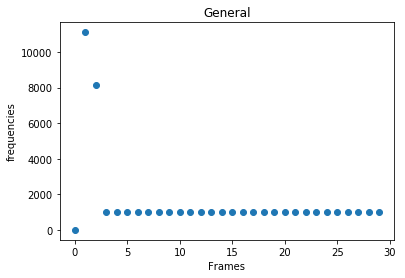

In [152]:
plt.plot(np.arange(30),bert_sents.numpy()[0][:30], 'o')
plt.xlabel("Frames")
plt.ylabel("frequencies")
plt.title("General")
plt.savefig('generated_song0.png')
plt.show()

In [138]:
spec = convert_back(bert_sents.numpy()[0])
np.shape(spec)

(104, 128)

In [139]:
spec = np.array(spec)
np.shape(spec)
mels = np.exp(spec)
db = librosa.power_to_db(mels, ref=np.max)

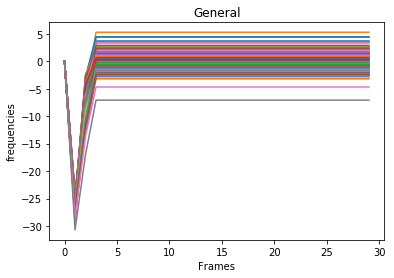

In [149]:
plt.plot(np.arange(30), spec[:30])
plt.xlabel("Frames")
plt.ylabel("frequencies")
plt.title("General")
plt.savefig('generated_song0.png')
plt.show()

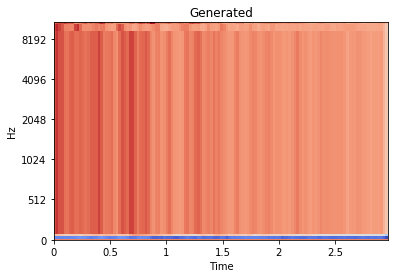

In [141]:
specshow(spec, y_axis='mel', x_axis='time')
plt.title("Generated")
plt.savefig("Generated_song0_spectrogram.png")

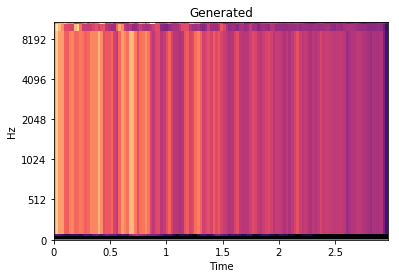

In [142]:
librosa.display.specshow(db, y_axis='mel', x_axis='time')
plt.title("Generated")
plt.savefig("Generated_db_song0_spectrogram.png")

In [143]:
original = convert_back(batches[0])

In [144]:
original = np.array(original)
np.shape(original)
mels_original = np.exp(original[:104])
dbo = librosa.power_to_db(mels_original, ref=np.max)

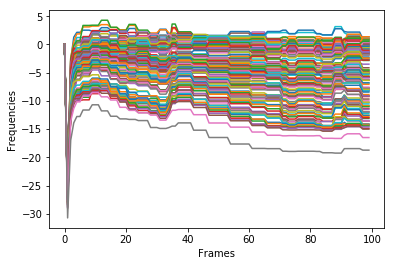

In [164]:
plt.plot(np.arange(100), original[:100])
plt.xlabel("Frames")
plt.ylabel("Frequencies")
# plt.title("Original")
plt.savefig('Original_100.png')
plt.show()

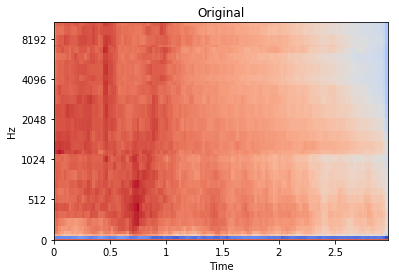

In [147]:
# print(type(original), np.shape(original))
specshow(original[:104], y_axis='mel', x_axis='time')
plt.title("Original")
plt.savefig("Original_song0_spectrogram.png")

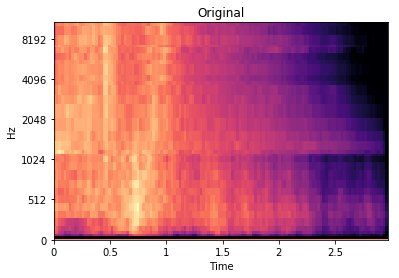

In [148]:
librosa.display.specshow(dbo, y_axis='mel', x_axis='time')
plt.title("Original")
plt.savefig("Original_db_song0_spectrogram.png")

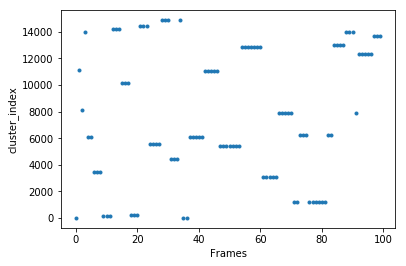

In [163]:
plt.plot(np.arange(100),batches[0][:100], '.')
plt.xlabel("Frames")
plt.ylabel("cluster_index")
# plt.title("General")
plt.savefig('vq.png')
plt.show()